*This is a brief notebook, but it is heavily reliant on the concepts covered in the [Single Lens](SingleLens.ipynb) notebook. If you have not completed that notebook, purhaps it would be best if you did that and then came back.*

In [9]:
# package imports (SHIFT + ENTER to run)
import numpy as np
import emcee
import MulensModel as mm
import matplotlib.pyplot as plt
import sys
import multiprocessing as mp
from IPython.display import display, clear_output

# The binary source model

Events matching a one-lens, two-sources model typically have lightcurves with smooth non-Paczynski shapes, such as the one in Jung et al. (2017), Figure 5, which is shown below. They are, in effect, two distinct Paczynski curves on top of each other; they do not create "sharp" perturbations from the primary Paczynski curve, like the binary-lens models typically do.

<style>
    table {
        margin-left: auto;
        margin-right: auto;
        width: 95%;
        text-align: center;
    }
</style>

| ![Jung 2017 Figure 5](./Assets/Jung2017-F5.jpg) | ![Jung 2017 Figure 3](./Assets/Jung2017-F3.jpg) |
| :-: | :-: |
| [Reproduction of Jung et al. (2017), Figure 5] Geometry and lightcurve of the binary-source model. *Top:* The upper panel shows the geometry of the binary-source model. Two straight lines with arrows are the source trajectories of individual source stars. The lens is located at the origin (marked by M), and the dotted circle is the angular Einstein ring. The red and blue filled circles represent the individual source positions at $\rm{HJD}'=7497$. Lengths are normalised by the Einstein radius. *Bottom:* The lower panel shows the enlarged view of the anomaly region. The two curves with different colours are best-fit binary-source models for $RI$ and $I$ passbands. The inset shows a zoom of the anomaly near $\rm{HJD}'\sim7501.4$. We note that, although we only use the $V$-band data for determining the source type, we also present the $V$-band model lightcurve to compare the colour change between passbands. | [Reproduction of Jung et al. (2017), Figure 3] Geometry and lightcurve of the binary lens model. *Top:* The upper panel shows the geometry of the binary lens model. The straight line with an arrow is the source trajectory, red closed concave curves represent the caustics, and blue filled circles (marked by $M_1$ and $M_2$) are the binary lens components. All length scales are normalised by the Einstein radius. The inset shows the general view and the major panel shows the enlarged view corresponding to the lightcurve of the lower panel. The open circle on the source trajectory is the source position at the time of observation whose size represents the source size. *Bottom:* The lower panel shows the enlarged view of the anomaly region. The inset shows a zoom of the lightcurve near $\rm{HJD}'\sim7501.4$. The curve superposed on the data is the best-fit binary lens model. |

The magnification model has the same parameterisation as the single lens model, except the flux model is a sum of two single-source magnifications multiplied by the flux of the source they are lensing:
$$ \mathbf{F}=\mathbf{A_1}F_{\rm S1}+\mathbf{A_2}F_{\rm S2}+F_{\rm B}, $$
where $\mathbf{A_1}$ and $F_{\rm S1}$ are the primary-source magnification model and flux, $\mathbf{A_2}$ and $F_{\rm S2}$ are the secondary-source magnification model and flux, $F_{\rm B}$ is the blend flux, and the models $\mathbf{A_1}$ and $\mathbf{A_2}$ share the same physical lens parameters $(D_{\rm L},\,M_{\rm L})$.

We can see the model in practice in the code cell below:

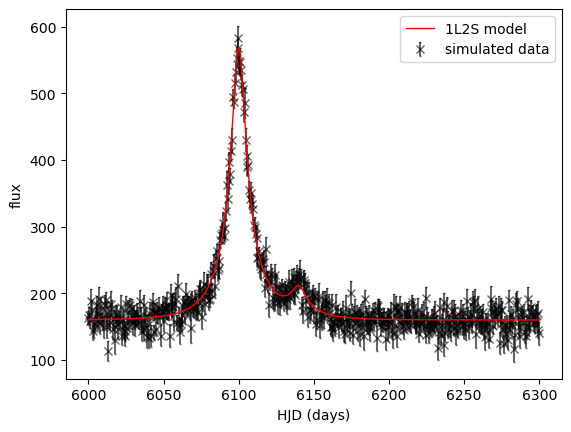

In [2]:
# A simulated binary source event

t01, u01 = 6100., 0.2  # primary source model parameters
t02, u02 = 6140., 0.2  # secondary source model parameters
t_E = 25.   # tE is not necessarily the same, due to orbital motion of the lens system, but we would expect 
            # tE to be mostly due to the relative propermotion of the lens and source systems.
flux1, flux_ratio, blend_flux = 100., 0.1, 50.
n = 500  # number of data points
time = np.linspace(6000., 6300., n)  # "data" epochs
N = 1000  # model plotting precision
T = np.linspace(6000., 6300., N)  # model time array

# building the individual magnification models for each source star
model1 = mm.Model({'t_0': t01, 'u_0': u01, 't_E': t_E})
A1 = model1.get_magnification(time)
model2 = mm.Model({'t_0': t02, 'u_0': u02, 't_E': t_E})
A2 = model2.get_magnification(time)

flux = A1 * flux1 + A2 * flux1*flux_ratio + blend_flux
flux_err = 3.0 *(np.abs(5.0 + np.random.normal(size=n)))  # flux uncertainties with mu=15 and std=3
error = flux_err * np.random.normal(size=n)     # offset the "meaasurments" by an amount that is dependent    
flux += error                                   # on the uncertainty
data = [time, flux, flux_err]

my_dataset = mm.MulensData(data, phot_fmt='flux')

plt.close(1)
plt.figure(1)

# Plot the data
plt.errorbar(time, flux, yerr=flux_err, 
             fmt='x', 
             ecolor='k', 
             capsize=1, 
             color='k', 
             alpha=0.6, 
             zorder=0,
             label='simulated data'
             )
# Plot the model
F = model1.get_magnification(T) * flux1 + model2.get_magnification(T) * flux1*flux_ratio + blend_flux
plt.plot(T, F, 
         color='r', 
         linestyle='-', 
         lw=1, 
         zorder=1, 
         label='1L2S model'
         )

plt.legend()
plt.xlabel(r'HJD (days)')
plt.ylabel(r'flux')
plt.show()

The measure of how far the data are from the model solution, scaled by the data uncertainties ($\chi^2$), is calculated using 
$$ \chi^2 = \sum\limits_i \frac{\left(F_i - x_i\right)^2} {\sigma_i^2}. $$ 
$\chi^2$ quantifies how likely a parameter set is to have generated the observed data, for a given model.

Similar to the procedure in the [Single Lens](SingleLens.ipynb) notebook, the maximum likelihood solution $(F_{\rm S1}, F_{\rm S2}, F_{\rm B})$ can therefore be found by solving for the minima of this function. As in the previous section, the minima occurs where the partial derivatives of the $\chi^2$ function are 0;
$$
    \frac{\partial\chi^2}{\partial F_{\rm S1}} = 0, 
    \frac{\partial\chi^2}{\partial F_{\rm S2}} = 0, 
    \frac{\partial\chi^2}{\partial F_{\rm B}} = 0.
$$
This linear regression problem can be written in the form
$$
\begin{matrix}
    \begin{bmatrix}
        \sum\limits_{i}\frac{A_{1,i}^{2}}{\sigma_{i}^{2}} & 
        \sum\limits_{i}\frac{A_{1,i}A_{2,i}}{\sigma_{i}^{2}} &
        \sum\limits_{i}\frac{A_{1,i}}{\sigma_{i}^{2}} \\ 
        \sum\limits_{i}\frac{A_{1,i}A_{2,i}}{\sigma_{i}^{2}} &
        \sum\limits_{i}\frac{A_{2,i}^{2}}{\sigma_{i}^{2}} & 
        \sum\limits_{i}\frac{A_{2,i}}{\sigma_{i}^{2}} \\ 
        \sum\limits_{i}\frac{A_{1,i}}{\sigma_{i}^{2}} &
        \sum\limits_{i}\frac{A_{2,i}}{\sigma_{i}^{2}} &
        \sum\limits_{i}\frac{1}{\sigma_{i}^{2}}
    \end{bmatrix}
    & \times &
    \begin{bmatrix}
        F_{\rm S1} \\ 
        F_{\rm S2} \\ 
        F_{\rm B}
    \end{bmatrix}
    & = &
    \begin{bmatrix}
        \sum\limits_{i}\frac{A_{1,i}x_{i}}{\sigma_{i}^{2}} \\ 
        \sum\limits_{i}\frac{A_{2,i}x_{i}}{\sigma_{i}^{2}} \\ 
        \sum\limits_{i}\frac{x_{i}}{\sigma_{i}^{2}}
    \end{bmatrix}
    \\
    \mathbf{B} &\times& \mathbf{\Theta} &=& \mathbf{C},
\end{matrix}
$$

which is solved following as follows:
$$ \mathbf{\Theta} = \mathbf{B}^{-1} \mathbf{C} = \frac{adj\,\mathbf{B}}{\det\mathbf{B}} \cdot \mathbf{C}. $$

<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 1</h2>
    <p>Use linear regression to determine the flux of the secondary source in the above example. Did you get out something similar to what you put in?</p>
    <br>
    <p>You may want to consider using functions from the numpy.linalg module.</p>
    <br>
</div>

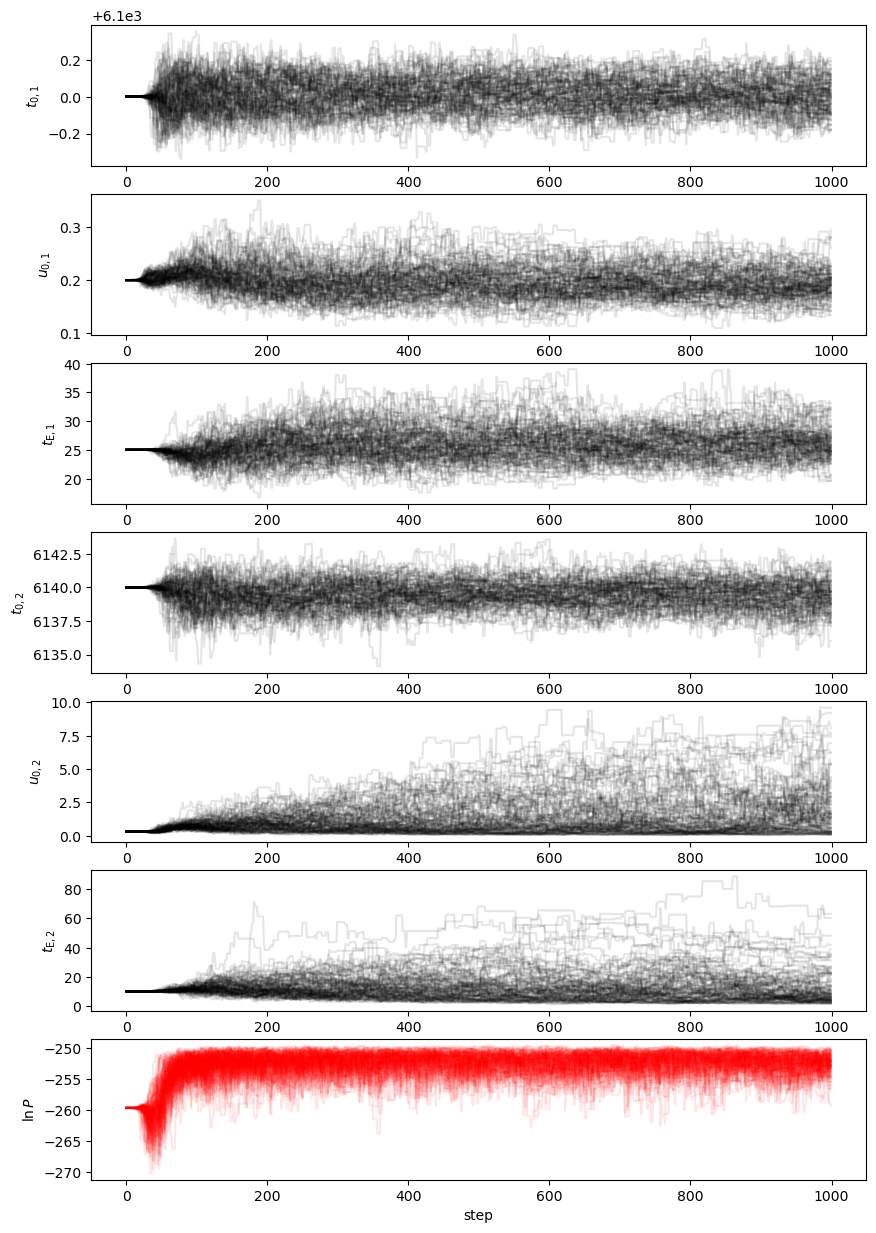

In [14]:
# source 2 flux used to generate the data
flux2 = flux1 * flux_ratio
print('secondary source flux used to generate the data:', flux2)

# objective function
def binary_source_chi2(theta: np.ndarray, model1, model2, data) -> float:
    """ chi2 function """
    #unpack the data
    t, flux, flux_err = data

    # model parameters being fit
    labels = ['t_0', 'u_0', 't_E']

    # change the values of model.parameters to those in theta.
    theta1 = theta[:3]
    theta2 = theta[3:]
    for (label, value1, value2) in zip(labels, theta1, theta2):
        setattr(model1.parameters, label, value1)
        setattr(model2.parameters, label, value2)
    
    # calculate the model magnification for each source
    A1 = model1.get_magnification(t)
    A2 = model2.get_magnification(t)

    # calculate the flux components
    C = np.array([np.sum(A1 * flux * flux_err**-2), np.sum(A2 * flux * flux_err**-2), np.sum(flux * flux_err**-2)])
    B = np.array([[np.sum(A1**2 * flux_err**-2), np.sum(A1 * A2 * flux_err**-2), np.sum(A1 * flux_err**-2)],
                  [np.sum(A1 * A2 * flux_err**-2), np.sum(A2**2 * flux_err**-2), np.sum(A2 * flux_err**-2)],
                  [np.sum(A1 * flux_err**-2), np.sum(A2 * flux_err**-2), np.sum(flux_err**-2)]])
    Theta = np.linalg.solve(B, C)  # ax=b <- B x Theta = C
    flux1, flux2, blend_flux = Theta

    # calculate the model flux
    model_flux = A1 * flux1 + A2 * flux2 + blend_flux
    chi2 = np.sum(((flux - model_flux) / flux_err)**2)

    if np.isnan(chi2) or np.isinf(chi2):
        print(f"NaN or inf encountered in chi2 calculation: theta={theta}, chi2={chi2}")
        return 1e16

    # After that, calculating chi2 is trivial:
    return chi2

def ln_prob(theta: np.ndarray, model1, model2, data) -> float:
    """log probability"""

    # priors
    if np.any(np.array(theta) < 0) or theta[0] > theta[3] or theta[0] < 6000 or theta[3] < 6000 or theta[0] > 6300 or theta[3] > 6300:
        return -1e16
    else:

        # Calculate chi2
        chi2 = binary_source_chi2(theta, model1, model2, data)

        # return the log probability
        if np.isnan(chi2) or np.isinf(chi2):
            print(f"NaN or inf encountered in ln_prob calculation: theta={theta}, chi2={chi2}")
            return 1e16
        else:
            return -0.5 * chi2


# initial guess
t01 = 6100
t02 = 6140
u01 = 0.2
u02 = 0.3
tE1 = 25
tE2 = 10

# fitting the model
theta0 = [t01, u01, tE1, t02, u02, tE2]
nwalkers = 100
ndim = len(theta0)
nsteps = 1000
step_size = 100

# starting lnL
lnP = ln_prob(theta0, model1, model2, data)
print('initial log probability:', lnP)

# Set up the sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, ln_prob, 
                                args=[model1, model2, data], 
                                threads=mp.cpu_count())
initial_pos = theta0 + 1e-6 * np.random.randn(nwalkers, ndim)

# Function to update the plot
def update_plot(sampler, nwalkers, fig, axes):
    ylabels = [r'$t_{0,1}$', r'$u_{0,1}$', r'$t_{\rm{E},1}$', 
               r'$t_{0,2}$', r'$u_{0,2}$', r'$t_{\rm{E},2}$',
               r'$\ln{P}$']
    for j in range(ndim):
        axes[j].clear()
        for i in range(nwalkers):
            axes[j].plot(sampler.chain[i, :, j], 'k', alpha=0.1)
        axes[j].set_ylabel(ylabels[j])
    
    axes[ndim].clear()
    for i in range(nwalkers):
        axes[ndim].plot(sampler.lnprobability[i], 'r', alpha=0.1)
    axes[ndim].set_ylabel(ylabels[ndim])
    axes[ndim].set_xlabel('step')

    clear_output(wait=True)
    display(fig)
    fig.canvas.draw()
    fig.canvas.flush_events()

# Create the figure and axes
fig, axes = plt.subplots(ndim + 1, 1, figsize=(10, 15));

# Run the sampler in steps and update the plot
i = 0
while i < nsteps:
    if i == 0:
        state = sampler.run_mcmc(initial_pos, step_size, progress=True)
    else:
        state = sampler.run_mcmc(state, step_size, progress=True)
    update_plot(sampler, nwalkers, fig, axes)
    i += step_size
clear_output(wait=True)

# Access the final state
final_state = sampler.get_last_sample()



<style>
.exercise {
    background-color: #E0E0E0;
    border-left: 8px solid #808080;
    padding: 10px 0 10px 20px;  /* top, right, bottom, left */
    margin: 20px 5px;  
    box-sizing: border-box;  
}
.exercise h2 {
    color: #808080;
    font-size: 24px;
}
.exercise p {
    margin: 0 20px;  /* Adjust this value to add space after the paragraph */
}
</style>

<div class="exercise">
    <h2>Exercise 2</h2>
    <p>Which binary-lens models have degenerate, binary-source, counter parts? </p>
    <br>
</div>

Write your answer here

Binary source events can throw a real spanner in the works when it comes to event modelling. Not only can they mimic caustic purturbations with a finite source effect, but they can also mess with colour-colour inference between observatories such as contemporaneous space-based observations, or late-time follow-up lens-flux and astrometric observations. With binaries possibly making up 40% or more of the stars in the Galactic centre ([Gautam et al., 2024](https://ui.adsabs.harvard.edu/abs/2024ApJ...964..164G); [McTier, Kipping, & Johnston, 2020](https://ui.adsabs.harvard.edu/abs/2020MNRAS.495.2105M)), this potential complication is not one that should be ignored.

## Next steps

Well, you've been warned. Now let's more on to something else. Maybe to one of these:
+ [Binary lenses](BinaryLens.ipynb)
+ [Higher-order effects]()
+ [The Galactic model](GalacticModel.ipynb)
+ [Modelling](Modelling.ipynb).

Okay, bye. I'll see you there.
